# (Frustratingly Easy) LLaVA OneVision Tutorial

We know that it's always beneficial to have a unified interface for different tasks. So we are trying to unify the interface for image, text, image-text interleaved, and video input. And in this tutorial, we aim to provide the most straightforward way to use our model. 

We use our 0.5B version as an example. This could be running on a GPU with 4GB memory. And with the following examples, you could see it's surprisingly have promising performance on understanding the image, interleaved image-text, and video. Tiny but mighty!

The same code could be used for 7B model as well.

## Inference Guidance

First please install our repo with code and environments: pip install git+https://github.com/LLaVA-VL/LLaVA-NeXT.git

Here is a quick inference code using [lmms-lab/qwen2-0.5b-si](https://huggingface.co/lmms-lab/llava-onevision-qwen2-0.5b-si) as an example. You will need to install `flash-attn` to use this code snippet. If you don't want to install it, you can set `attn_implementation=None` when load_pretrained_model

### Image Input
Tackling the single image input with LLaVA OneVision is pretty straightforward.

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

import sys
import warnings

warnings.filterwarnings("ignore")
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-si"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
cache_dir = "/dpc/kunf0097/cache/models"
tokenizer, model, image_processor, max_length = load_pretrained_model(model_path, None, model_name, device_map=device_map, cache_dir=cache_dir)  # Add any other thing you want to pass in llava_model_args

model.eval()

In [ ]:


url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "qwen_1_5"  # Make sure you use correct chat template for different models
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]


cont = model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs)

You could use the following code to make it streaming in terminal, this would be pretty useful when creating a chatbot.

In [ ]:
from threading import Thread
from transformers import TextIteratorStreamer
import json

url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "qwen_1_5"
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]

max_context_length = getattr(model.config, "max_position_embeddings", 2048)
num_image_tokens = question.count(DEFAULT_IMAGE_TOKEN) * model.get_vision_tower().num_patches

streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True, timeout=15)

max_new_tokens = min(4096, max_context_length - input_ids.shape[-1] - num_image_tokens)

if max_new_tokens < 1:
    print(
        json.dumps(
            {
                "text": question + "Exceeds max token length. Please start a new conversation, thanks.",
                "error_code": 0,
            }
        )
    )
else:
    gen_kwargs = {
        "do_sample": False,
        "temperature": 0,
        "max_new_tokens": max_new_tokens,
        "images": image_tensor,
        "image_sizes": image_sizes,
    }

    thread = Thread(
        target=model.generate,
        kwargs=dict(
            inputs=input_ids,
            streamer=streamer,
            **gen_kwargs,
        ),
    )
    thread.start()

    generated_text = ""
    for new_text in streamer:
        generated_text += new_text
        print(generated_text, flush=True)
        # print(json.dumps({"text": generated_text, "error_code": 0}), flush=True)

    print("Final output:", generated_text)

### Image-Text Interleaved Input

Now switching to our onevision model for more complex tasks. You should start to use `llava-onevision-qwen2-0.5b-ov` for image-text interleaved input and video input.

Processing image-text interleaved input is a bit more complicated. But following the code below should work.

In [ ]:
# Load model
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
llava_model_args = {
        "multimodal": True,
    }
overwrite_config = {}
overwrite_config["image_aspect_ratio"] = "pad"
llava_model_args["overwrite_config"] = overwrite_config
tokenizer, model, image_processor, max_length = load_pretrained_model(model_path, None, model_name, device_map=device_map, **llava_model_args)

model.eval()

# Load two images
url1 = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
url2 = "https://raw.githubusercontent.com/haotian-liu/LLaVA/main/images/llava_logo.png"

image1 = Image.open(requests.get(url1, stream=True).raw)
image2 = Image.open(requests.get(url2, stream=True).raw)

images = [image1, image2]
image_tensors = process_images(images, image_processor, model.config)
image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]

# Prepare interleaved text-image input
conv_template = "qwen_1_5"
question = f"{DEFAULT_IMAGE_TOKEN} This is the first image. Can you describe what you see?\n\nNow, let's look at another image: {DEFAULT_IMAGE_TOKEN}\nWhat's the difference between these two images?"

conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size for image in images]

# Generate response
cont = model.generate(
    input_ids,
    images=image_tensors,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs[0])

### Video Input

Now let's try video input. It's the same as image input, but you need to pass in a list of video frames. And remember to set the `<image>` token only once in the prompt, e.g. "<image>\nWhat is shown in this video?", not "<image>\n<image>\n<image>\nWhat is shown in this video?". Since we trained on this format, it's important to keep the format consistent.

In [1]:
import torch
torch.cuda.device_count()

2

In [7]:
from llava.model.builder import load_pretrained_model_simplified, connect_parent_lm_head
from llava.mm_utils import tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX
from llava.conversation import conv_templates

import numpy as np
import copy
import warnings
from decord import VideoReader, cpu

warnings.filterwarnings("ignore")

model_path = "/dpc/kunf0097/out/checkpoints/lora-llava-qwen-ov-wzno-1007_102328/"
model_base = "/dpc/kunf0097/.cache/huggingface/hub/llava-qwen-ov-wz-1004_123605/" 
# model_base =  "lmms-lab/llava-onevision-qwen2-0.5b-ov" #
# model_base =  None
model_name = "lora_llava_qwen"
device_map = {"":0}

tokenizer, model, image_processor, max_length = load_pretrained_model_simplified(model_path, model_base, model_name, device_map=device_map, attn_implementation=None)

{'device_map': {'': 0}, 'torch_dtype': torch.float16}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading LLaVA from base model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading vision tower: google/siglip-so400m-patch14-384
Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...
Model Class: LlavaQwenForCausalLM


In [4]:
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
model_name = "llava_qwen"
model = connect_parent_lm_head(model, model_path, model_name, device_map)


{'device_map': {'': 0}, 'torch_dtype': torch.float16}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384
Model Class: LlavaQwenForCausalLM


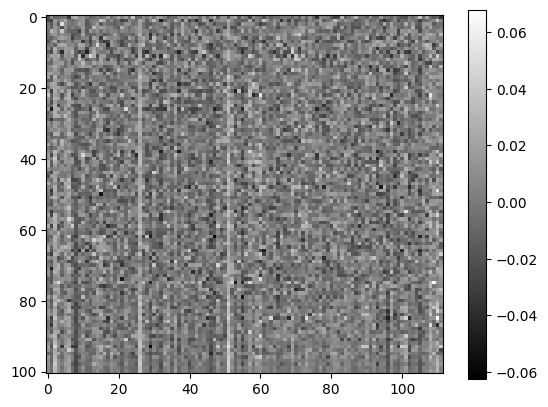

In [9]:
import matplotlib.pyplot as plt
a = model.lm_head.weight.data.cpu().numpy()
b = a[::a.shape[0]//100,::a.shape[1]//100]
plt.imshow(b, cmap="gray")
plt.colorbar()
plt.show()

In [11]:
# save model and tokenizer
save_path = "/dpc/kunf0097/.cache/huggingface/hub/lora-llava-qwen-ov-wzno-1007_102328/"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


('/dpc/kunf0097/.cache/huggingface/hub/lora-llava-qwen-ov-wzno-1007_102328/tokenizer_config.json',
 '/dpc/kunf0097/.cache/huggingface/hub/lora-llava-qwen-ov-wzno-1007_102328/special_tokens_map.json',
 '/dpc/kunf0097/.cache/huggingface/hub/lora-llava-qwen-ov-wzno-1007_102328/vocab.json',
 '/dpc/kunf0097/.cache/huggingface/hub/lora-llava-qwen-ov-wzno-1007_102328/merges.txt',
 '/dpc/kunf0097/.cache/huggingface/hub/lora-llava-qwen-ov-wzno-1007_102328/added_tokens.json')

In [5]:
ex =  {
    "id": "cctv052x2004080517x01660",
    "video": "/dpc/kunf0097/data/high/video/cctv052x2004080517x01660.avi",
    "conversations": [
        {
            "from": "human",
            "value": "<image>From the video provided along with scene description and observed features assess the Severity out of 5 and the most probable cause.\n\n#### Scene description: Context: weather: overcast, time: 17:00, congestion: heavy\n\n####Observed features:\nNo collision detected. Road type: Road type not explicitly mentioned; possibly a major urban road due to heavy congestion.. Pedestrian involvement: None observed; typical for congested vehicle roads.. Weather conditions: Overcast conditions reported.. Visibility: Likely reduced due to overcast weather, although still possibly acceptable.. Number of vehicles/density: High vehicular density implied by \"heavy\" congestion.. Time of day: It's inferred as late afternoon or early evening, close to peak hours.. Road blockages or detours: Not explicitly mentioned, but road conditions likely contributing to congestion."
        },
        {
            "from": "gpt",
            "value": "Severity of congestion: 4 (The combination of time of day likely being during rush hour and potential reduced visibility due to overcast weather contributes significantly to the severity of congestion.). The probable cause of the heavy congestion is likely the combination of peak hour traffic during late afternoon and the overcast weather contributing to less effective traffic flow."
        }
    ]
}

In [10]:
# Function to extract frames from video
def load_video(video_path, max_frames_num):
    if type(video_path) == str:
        vr = VideoReader(video_path, ctx=cpu(0))
    else:
        vr = VideoReader(video_path[0], ctx=cpu(0))
    total_frame_num = len(vr)
    uniform_sampled_frames = np.linspace(0, total_frame_num - 1, max_frames_num, dtype=int)
    frame_idx = uniform_sampled_frames.tolist()
    spare_frames = vr.get_batch(frame_idx).asnumpy()
    return spare_frames  # (frames, height, width, channels)


# Load and process video
# video_path = "/home/kunet.ae/ku5001069/LLaVA-NeXT/docs/jobs.mp4"
video_path = ex["video"] #"/dpc/kunf0097/data/hwid12/c204391a-ff4e-49cb-9c94-7210ca254bc1.mp4"
video_frames = load_video(video_path, 16)
print(video_frames.shape) # (16, 1024, 576, 3)
image_tensors = [] 
frames = image_processor.preprocess(video_frames, return_tensors="pt")["pixel_values"].half().cuda()
image_tensors.append(frames)

# Prepare conversation input
conv_template = "qwen_1_5"
question = ex["conversations"][0]["value"]
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()
print(prompt_question)

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(model.device)
image_sizes = [frame.size for frame in video_frames]

# Generate response
cont = model.generate(
    input_ids,
    images=image_tensors,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=256,
    modalities=["video"],
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs[0])

[msmpeg4v1 @ 0xfbba1780] ext header missing, 6 left


(16, 240, 320, 3)
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<image>From the video provided along with scene description and observed features assess the Severity out of 5 and the most probable cause.

#### Scene description: Context: weather: overcast, time: 17:00, congestion: heavy

####Observed features:
No collision detected. Road type: Road type not explicitly mentioned; possibly a major urban road due to heavy congestion.. Pedestrian involvement: None observed; typical for congested vehicle roads.. Weather conditions: Overcast conditions reported.. Visibility: Likely reduced due to overcast weather, although still possibly acceptable.. Number of vehicles/density: High vehicular density implied by "heavy" congestion.. Time of day: It's inferred as late afternoon or early evening, close to peak hours.. Road blockages or detours: Not explicitly mentioned, but road conditions likely contributing to congestion.<|im_end|>
<|im_start|>assistant

Severity 